In [1]:
import numpy as np
from numpy.random import uniform, exponential
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set(style='whitegrid')
from lifelines import KaplanMeierFitter, NelsonAalenFitter
from lifelines.plotting import plot_lifetimes

**Survival analysis** is a versatile technique which can be applied to many use cases. It is used to model the time between 'birth' and 'death' events based on historical data. 

The core idea begind it is that we have two kinds of datapoints:
1. 'Complete' datapoints for which we observe their end state (the death event)
2. 'Incomplete' datapoints for which we know that they are alive *so far* (but do not know how much longer they will be alive). These are called **censored**.

The terms of 'life' and 'death' here are a historical remnant of the domain which birthed this technique (predicting survival of patients) but in practice these events could be represented, as an example, by customer acquisition and churn respectively. 

# Creating dummy data

In [2]:
N = 25
CURRENT_TIME = 10

In [3]:
np.random.seed(42)

actual_lifetimes = np.array([
    exponential(12) if (uniform() < 0.5) else exponential(2) for i in range(N)
])
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME

actual_lifetimes2 = np.array([
    exponential(12) if (uniform() < 0.1) else exponential(2) for i in range(N)
])
observed_lifetimes2 = np.minimum(actual_lifetimes2, CURRENT_TIME)
death_observed2 = actual_lifetimes2 < CURRENT_TIME

df = pd.DataFrame({
    'actual_lifetimes': actual_lifetimes.tolist() + actual_lifetimes2.tolist(),
    'observed_lifetimes': observed_lifetimes.tolist() + observed_lifetimes2.tolist(),
    'death_observed': death_observed.tolist() + death_observed2.tolist(),
    'group': [1]*N + [2]*N,
})
print(df.shape)
df.head()

(50, 4)


,actual_lifetimes,observed_lifetimes,death_observed,group
0,36.121457,10.000000,False,1
1,1.825885,1.825885,True,1
2,2.035156,2.035156,True,1
3,24.134770,10.000000,False,1
4,2.462500,2.462500,True,1


Just like we need a certain kind of dataset to do supervised machine learning (labeled X and Y pairs), this is the basic kind of data we need to do survival analysis. 

Each row/datapoint is one person who lives for a certain 'lifetime'. We are looking at the data for a certain snapshot($t=10$ for this example) in time and at this time some people in the data will have already died so these are considered 'complete'. The rest of the people are alive *so far* so we call them **censored**. 

In this dummy dataset we can distinguish between the two types by looking at the columns `actual_lifetimes` and `observed_lifetimes`. 

There is also a `group` column. Consider this some kind of demographic indicator (sex, affluency etc) which we will add to the analysis a little later. 

For all people in the data their `observed_lifetimes` is less than or equal to their `actual_lifetimes`. This will always be true. 

In [4]:
(df['observed_lifetimes'] <= df['actual_lifetimes']).all()

True

Also, the `observed_lifetimes` and `actual_lifetimes` are equal for only those people who are *not censored* (i.e. their deaths have been observed).

In [5]:
((df['actual_lifetimes'] == df['observed_lifetimes']) == df['death_observed']).all()

True

C:\Users\Rabeez Riaz\Anaconda3\lib\site-packages\lifelines\plotting.py:702: UserWarning: For less visual clutter, you may want to subsample to less than 25 individuals.
  warnings.warn("For less visual clutter, you may want to subsample to less than 25 individuals.")


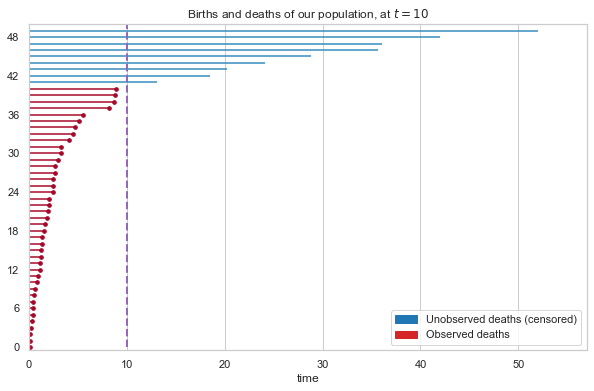

In [6]:
fig, ax = plt.subplots(figsize=(10,6))
plot_lifetimes(df['actual_lifetimes'], event_observed=df['death_observed'], ax=ax)
blue_patch = mpatches.Patch(color='tab:blue', label='Unobserved deaths (censored)')
red_patch = mpatches.Patch(color='tab:red', label='Observed deaths')
ax.legend(handles=[blue_patch,red_patch], loc='lower right')
ax.grid(False, axis='y')
ax.set_xlim(0, df['actual_lifetimes'].max()+5)
ax.vlines(CURRENT_TIME, 0, N*2+5, lw=2, linestyles='--', color='tab:purple')
ax.set_xlabel("time")
ax.set_title(f"Births and deaths of our population, at $t={CURRENT_TIME}$");

This chart shows the lifetimes of all 50 people in our dataset. The purple vertical line is the current snapshot (i.e. where we are looking from). 

Each horizontal line is the life of a person. The red ones are complete and we can see that they died at some point before 10. 

The blue ones go beyond the purple line that means they were alive at $t=10$ and died sometime after that. In practice we do not know this future information and survival analysis helps us quantify probabilities accounting for this unknown. 

# Survival function

The 'output' of survival analysis is generally something called a *cummulative survival curve*. It tells us the probability of being seen alive (surviving) at different points in time. 

The `lifelines` python package provides a familiar sklearn-style interface to all its models. 

Here we fit a survival curve model with 50 datapoints including 9 right-censored (the blue people from above chart).

In [7]:
kmf = KaplanMeierFitter()
kmf.fit(durations=df['observed_lifetimes'], 
        event_observed=df['death_observed'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 50 total observations, 9 right-censored observations>

We can visualize what the model has learned using the following code and create a chart manually. 

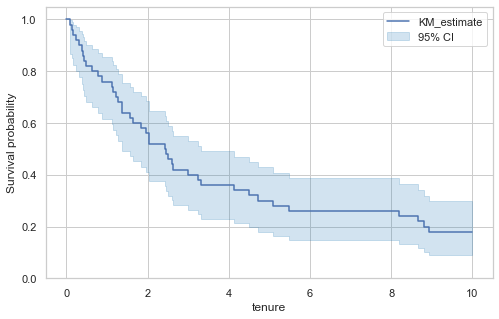

In [8]:
fig, ax = plt.subplots(figsize=(8,5))
kmf.survival_function_.plot(drawstyle='steps-post', ax=ax)
ax.fill_between(kmf.confidence_interval_.index, 
                kmf.confidence_interval_['KM_estimate_lower_0.95'], 
                kmf.confidence_interval_['KM_estimate_upper_0.95'],
                step='post', color='tab:blue', alpha=0.2, label='95% CI')
ax.set(xlabel='tenure', ylabel='Survival probability')
ax.legend()
ax.set_ylim(0,1.05);

But, the package provides a simple function to do it for us with some extra bells and whistles. Let's take a look.

The x-axis is the time and the y-axis is the survival probability. It starts from 100% and drops after that. Notice that the curve is non-increasing (it only goes down or stays constant) adn that it never reaches 0. This second point is important because this is the information the model has kept about the 9 censored observations. Even at the final time point $t=10$ we do not see survival probability go to 0 because the censored people show that their is a chance of surviving beyond the end of the data. 

The shaded region is a 95% confidence interval around the blue line which is the expected survival probability (mean value). The interval represents the uncertainty in the data. As expected, the uncertainty is low in the beginning and increases as we have fewer and fewer deaths happening. 

The numbers at the bottom tell the same story. 'At risk' means people who are alive so far. 'Events' is death events and 'Censored' is alive people leftover when time runs out.  

A common summary statistic used for these curves is the *median survival time* which for our example will be ~2.5

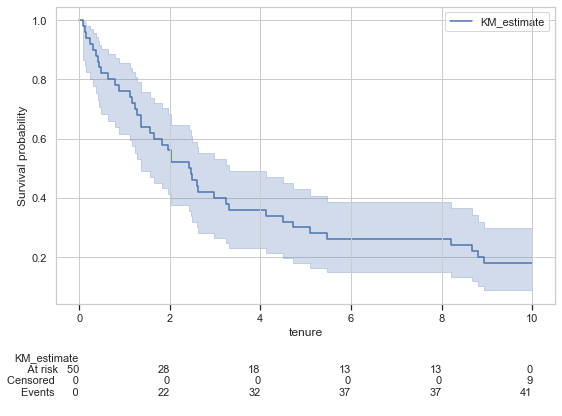

In [9]:
ax = kmf.plot_survival_function(at_risk_counts=True, figsize=(8,6))
ax.set(xlabel='tenure', ylabel='Survival probability')
ax.legend();

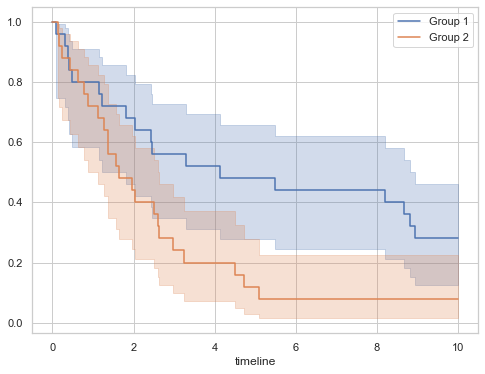

In [10]:
fig, ax = plt.subplots(figsize=(8,6))

kmf.fit(df.loc[df['group'] == 1, 'observed_lifetimes'], event_observed=df.loc[df['group'] == 1, 'death_observed'], label="Group 1")
kmf.plot_survival_function(ax=ax);

kmf.fit(df.loc[df['group'] == 2, 'observed_lifetimes'], event_observed=df.loc[df['group'] == 2, 'death_observed'], label="Group 2")
kmf.plot_survival_function(ax=ax);

Let's suppose this data is for ecommerce customers where the birth is account creation and death is first purchase. Remember the `group` column in our data, let's say that Group1 are people who created their account the normal way and Group2 are people who created their account via an referral link. 

*Notice that in this scenario 'death' is a good thing.*

We can clearly see that the referral people (Group2, orange) are a much healthier customer segment - their median survival time is almost half of the other group and almost all of them 'die' (make a purchase) by $t=5$. 

We will go through a similar example using real data in the second notebook. 

# Hazard function

Another common output of survival analysis is the *Hazard curve*. This is conceptually the opposite of the survival curve. A lot of more complex methods in survival analysis use hazard function instead of survival function so we will quickly see what it looks like. 

This flowchart shows the usual functions used in this domain and how they relate with each other.

<img style='background-color:white' width=500px src='https://lifelines.readthedocs.io/en/latest/_images/map.png'></img>
*image from lifelines documentation*

Again, sklearn-style interface jsut a different class this time. 

In [11]:
naf = NelsonAalenFitter()
naf.fit(df['observed_lifetimes'], event_observed=df['death_observed'])

<lifelines.NelsonAalenFitter:"NA_estimate", fitted with 50 total observations, 9 right-censored observations>

Similar plotting functionality also available for hazard. 

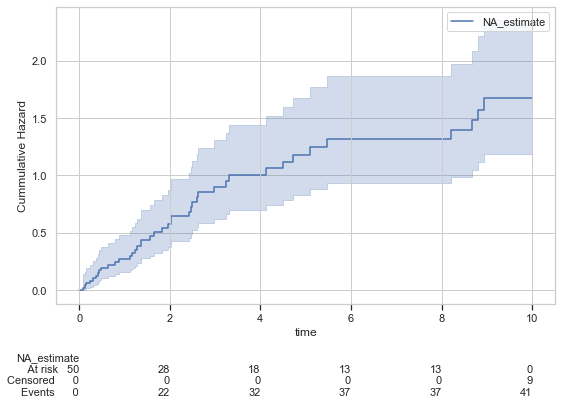

In [12]:
ax = naf.plot_cumulative_hazard(at_risk_counts=True, figsize=(8,6))
ax.set(xlabel='time', ylabel='Cummulative Hazard');

In the model we calculate the cummulative hazard instead of pointwise hazard (notice there is no direct link between survival and hazard) because the calculation is more numerically stable. We can get pointwise hazard curve by doing a smoothed differencing operation (builtin package function used here). 

Interpretation of this plot is similar to survival curve with only 2 notable differences:
1. Cummulative hazard is non-decreasing
2. It is unbounded in positive direction

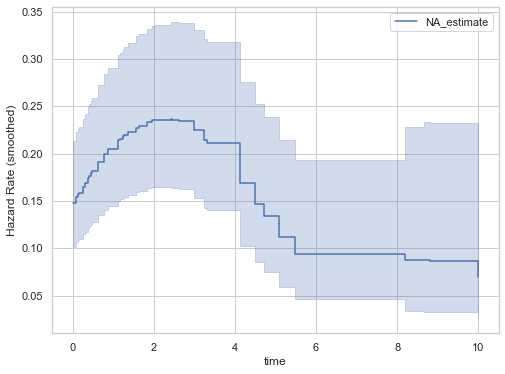

In [13]:
ax = naf.plot_hazard(bandwidth=3, figsize=(8,6))
ax.set(xlabel='time', ylabel='Hazard Rate (smoothed)');

The interpretation of pointwise hazard curve is a little difference. It is helpfull to think of the y-axis as 'danger' (ignoring the negative connotation in the word). 

The danger keeps increasing from the beginning untill $t=2$ where it goes back down and stays constant until the end.